### 1. Setup

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats

from utils import data_prep as dp, feature_gen as fg, feature_select as fs, backtest as bt

### 2. Load & Clean Data

In [2]:
exchange = "binance"

start_date = "20230101"
end_date = "20241231"

start_dt = dt.datetime.strptime(start_date, "%Y%m%d")
end_dt = dt.datetime.strptime(end_date, "%Y%m%d")

In [3]:
level1_data = dp.get_files(start_dt, end_dt, "level1", exchange, "futures", "BTCUSDT")
book_data = dp.get_files(start_dt, end_dt, "book", exchange, "futures", "BTCUSDT")
trade_data = dp.get_files(start_dt, end_dt, "trade", exchange, "futures", "BTCUSDT")

level1_data.shape, book_data.shape, trade_data.shape

((1052640, 28), (1052640, 63), (1052640, 23))

In [4]:
# Convert timestamps to datetime
level1_data['ts_end'] = pd.to_datetime(level1_data['ts_end'], unit='ms')
book_data[['ts_end', 'ts_book']] = book_data[['ts_end', 'ts_book']].apply(pd.to_datetime, unit='ms')
trade_data['ts_end'] = pd.to_datetime(trade_data['ts_end'], unit='ms')

# Set index to ts_end
level1_data.set_index('ts_end', inplace=True)
book_data.set_index('ts_end', inplace=True)
trade_data.set_index('ts_end', inplace=True)

# Align time series data
(level1_data, book_data, trade_data), start, end = dp.align_ts(level1_data, book_data, trade_data)

# Create a common time index
time_idx = pd.date_range(start=start, end=end, freq='1min')

time_idx[[0, -1]]

DatetimeIndex(['2023-01-01 00:01:00', '2024-12-31 23:59:00'], dtype='datetime64[ns]', freq=None)

In [5]:
# Compute log return
level1_data['log_return'] = np.log(level1_data['close_mid'] / level1_data['close_mid'].shift(1))

### 3. Build Feature

In [6]:
taus = [1, 5, 15, 30, 60, 120]
features_df = fg.build_features(level1_data, book_data, trade_data, taus)
features_df.tail()

,log_ret_1m,log_ret_5m,log_ret_15m,log_ret_30m,log_ret_60m,log_ret_120m,abs_ret_1m,abs_ret_5m,abs_ret_15m,abs_ret_30m,...,minute,sin_minute,cos_minute,day_of_week,sin_dow,cos_dow,is_weekend,is_dst,is_hour_start,is_hour_end
ts_end,,,,,,,,,,,,,,,,,,,,,
2024-12-31 23:55:00,-0.000195,0.001075,0.001974,0.000179,0.001293,-0.002405,0.000195,0.001075,0.001974,0.000179,...,55,-0.500000,0.866025,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:56:00,0.000270,0.000669,0.002396,0.000500,0.001450,-0.002150,0.000270,0.000669,0.002396,0.000500,...,56,-0.406737,0.913545,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:57:00,-0.000425,-0.000425,0.001477,-0.000932,0.001668,-0.002794,0.000425,0.000425,0.001477,0.000932,...,57,-0.309017,0.951057,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:58:00,-0.000265,-0.000940,0.001383,-0.001241,0.001598,-0.003313,0.000265,0.000940,0.001383,0.001241,...,58,-0.207912,0.978148,1,0.781831,0.62349,0,0,0,1
2024-12-31 23:59:00,-0.000155,-0.000770,0.001436,-0.001345,0.001532,-0.003760,0.000155,0.000770,0.001436,0.001345,...,59,-0.104528,0.994522,1,0.781831,0.62349,0,0,0,1


### 4. Build Target

In [7]:
target_df = fg.target_rv(level1_data, horizons=[60])
target_df.head()

,target_rv_fwd60m
ts_end,
2023-01-01 00:01:00,0.158508
2023-01-01 00:02:00,0.158838
2023-01-01 00:03:00,0.159852
2023-01-01 00:04:00,0.157915
2023-01-01 00:05:00,0.158012


### 5. Combine Features & Target

In [8]:
df = pd.concat([features_df, target_df], axis=1)
df = df.dropna(axis=0)
df.head()

,log_ret_1m,log_ret_5m,log_ret_15m,log_ret_30m,log_ret_60m,log_ret_120m,abs_ret_1m,abs_ret_5m,abs_ret_15m,abs_ret_30m,...,sin_minute,cos_minute,day_of_week,sin_dow,cos_dow,is_weekend,is_dst,is_hour_start,is_hour_end,target_rv_fwd60m
ts_end,,,,,,,,,,,,,,,,,,,,,
2023-01-01 02:01:00,-0.000502,-0.000212,0.000333,0.000738,0.001089,0.000254,0.000502,0.000212,0.000333,0.000738,...,0.104528,0.994522,6,-0.781831,0.62349,1,0,1,0,0.112397
2023-01-01 02:02:00,0.000169,-0.000296,0.000363,0.000968,0.001046,0.000605,0.000169,0.000296,0.000363,0.000968,...,0.207912,0.978148,6,-0.781831,0.62349,1,0,1,0,0.111795
2023-01-01 02:03:00,-0.000054,-0.000514,0.000248,0.000913,0.000701,0.000768,0.000054,0.000514,0.000248,0.000913,...,0.309017,0.951057,6,-0.781831,0.62349,1,0,1,0,0.114303
2023-01-01 02:04:00,-0.000175,-0.000622,0.000091,0.000738,0.000550,0.000859,0.000175,0.000622,0.000091,0.000738,...,0.406737,0.913545,6,-0.781831,0.62349,1,0,1,0,0.113171
2023-01-01 02:05:00,0.000000,-0.000562,-0.000109,0.000774,0.000702,0.000720,0.000000,0.000562,0.000109,0.000774,...,0.500000,0.866025,6,-0.781831,0.62349,1,0,0,0,0.113172


### 6. Walk-Forward CV

In [9]:
folds = [
    ("2023-01-01", "2023-09-30", "2023-10-01", "2023-12-31"), # fold 1
    ("2023-04-01", "2023-12-31", "2024-01-01", "2024-03-31"), # fold 2
    ("2023-07-01", "2024-03-31", "2024-04-01", "2024-06-30"), # fold 3
]

target = target_df.columns[0]

In [10]:
num_leaves_list = [31, 63, 127]
learning_rates  = [0.05, 0.10]

param_grid = [
    {"num_leaves": nl, "learning_rate": lr, "n_estimators": 300}
    for nl in num_leaves_list
    for lr in learning_rates
]

In [11]:
def train_lgb(train_df, val_df, feats, target, params):
    model = lgb.LGBMRegressor(
        num_leaves=params["num_leaves"],
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        subsample=0.9,
        colsample_bytree=0.9,
        verbose=-1,
        random_state=42
    )

    model.fit(train_df[feats], train_df[target])
    pred = model.predict(val_df[feats])

    rmse = mean_squared_error(val_df[target], pred) ** 0.5
    mae  = mean_absolute_error(val_df[target], pred)
    ic   = stats.spearmanr(pred, val_df[target]).correlation

    return rmse, mae, ic

In [12]:
tuning_results = []

for p_i, params in enumerate(param_grid, 1):
    print(f"\nHyperparameter set {p_i}/{len(param_grid)}: {params}")
    fold_scores = []

    for f_i, (tr_start, tr_end, va_start, va_end) in enumerate(folds, 1):
        print(f"\nFold {f_i}")
        print(f"  Training window:   {tr_start} to {tr_end}")
        print(f"  Validation window: {va_start} to {va_end}")

        train_df = df[(df.index >= tr_start) & (df.index <= tr_end)]
        val_df   = df[(df.index >= va_start) & (df.index <= va_end)]

        print("  Selecting features (IC ranking)...")
        feats_ic, ic_series = fs.select_ic(train_df, target)

        print("  Pruning correlated features...")
        feats, _, _ = fs.prune_corr(train_df, feats_ic, ic_series)

        print(f"  Features used: {len(feats)}")

        print("  Training model...")
        rmse, mae, ic = train_lgb(train_df, val_df, feats, target, params)

        print(f"  Fold {f_i} RMSE={rmse:.4f}, MAE={mae:.4f}, IC={ic:.4f}")

        fold_scores.append({"rmse": rmse, "mae": mae, "ic": ic})

    avg_rmse = np.mean([s["rmse"] for s in fold_scores])
    avg_mae  = np.mean([s["mae"]  for s in fold_scores])
    avg_ic   = np.mean([s["ic"]   for s in fold_scores])

    tuning_results.append({
        "params": params,
        "avg_rmse": avg_rmse,
        "avg_mae": avg_mae,
        "avg_ic": avg_ic
    })

    print(f"\nFinished hyperparameter set {p_i}")
    print(f"  Average RMSE={avg_rmse:.4f}, MAE={avg_mae:.4f}, IC={avg_ic:.4f}")


Hyperparameter set 1/6: {'num_leaves': 31, 'learning_rate': 0.05, 'n_estimators': 300}

Fold 1
  Training window:   2023-01-01 to 2023-09-30
  Validation window: 2023-10-01 to 2023-12-31
  Selecting features (IC ranking)...
  Pruning correlated features...
  Features used: 14
  Training model...
  Fold 1 RMSE=0.2340, MAE=0.1032, IC=0.7832

Fold 2
  Training window:   2023-04-01 to 2023-12-31
  Validation window: 2024-01-01 to 2024-03-31
  Selecting features (IC ranking)...
  Pruning correlated features...
  Features used: 19
  Training model...
  Fold 2 RMSE=0.2703, MAE=0.1375, IC=0.8041

Fold 3
  Training window:   2023-07-01 to 2024-03-31
  Validation window: 2024-04-01 to 2024-06-30
  Selecting features (IC ranking)...
  Pruning correlated features...
  Features used: 19
  Training model...
  Fold 3 RMSE=0.2136, MAE=0.1515, IC=0.7879

Finished hyperparameter set 1
  Average RMSE=0.2393, MAE=0.1307, IC=0.7918

Hyperparameter set 2/6: {'num_leaves': 31, 'learning_rate': 0.1, 'n_estim

In [13]:
tuning_results_sorted = sorted(tuning_results, key=lambda x: -x["avg_ic"])
best_params = tuning_results_sorted[0]["params"]

print("\nBest hyperparameters based on IC:")
print(best_params)


Best hyperparameters based on IC:
{'num_leaves': 31, 'learning_rate': 0.05, 'n_estimators': 300}


### 8. Train Final Model

In [14]:
pretest_df = df[: "2024-06-30"]
test_df    = df["2024-07-01":]

# Feature selection on ALL pre-test data
feats_ic, ic_series = fs.select_ic(pretest_df, target)
feats, _, _ = fs.prune_corr(pretest_df, feats_ic, ic_series)

# Final model training
final_model = lgb.LGBMRegressor(
    num_leaves=best_params["num_leaves"],
    learning_rate=best_params["learning_rate"],
    n_estimators=best_params["n_estimators"],
    subsample=0.9,
    colsample_bytree=0.9,
    verbose=-1,
    random_state=42
)

final_model.fit(pretest_df[feats], pretest_df[target])
oos_pred = final_model.predict(test_df[feats])

rmse = mean_squared_error(test_df[target], oos_pred)**0.5
mae  = mean_absolute_error(test_df[target], oos_pred)
ic   = stats.spearmanr(oos_pred, test_df[target]).correlation

print("\nFinal OOS Performance")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"IC  : {ic:.4f}")


Final OOS Performance
RMSE: 0.1996
MAE : 0.1145
IC  : 0.8031


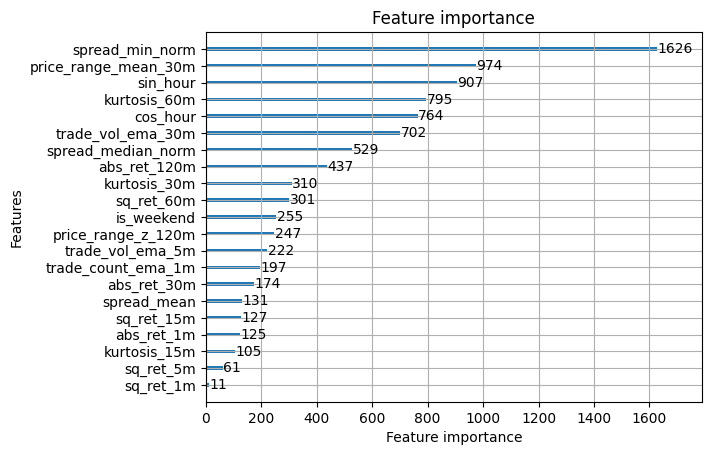

In [15]:
lgb.plot_importance(final_model)
plt.show()

### Backtest

Median of pre-test realized vol: 0.3191



Category,Buy & Hold,Vol-Managed
Metric_Name,,
Max DD,-0.2955,-0.1709
PnL,0.4425,0.3078
Sharpe,1.6310,1.7765
Sortino,2.1726,2.5935
Volatility,0.5402,0.3450


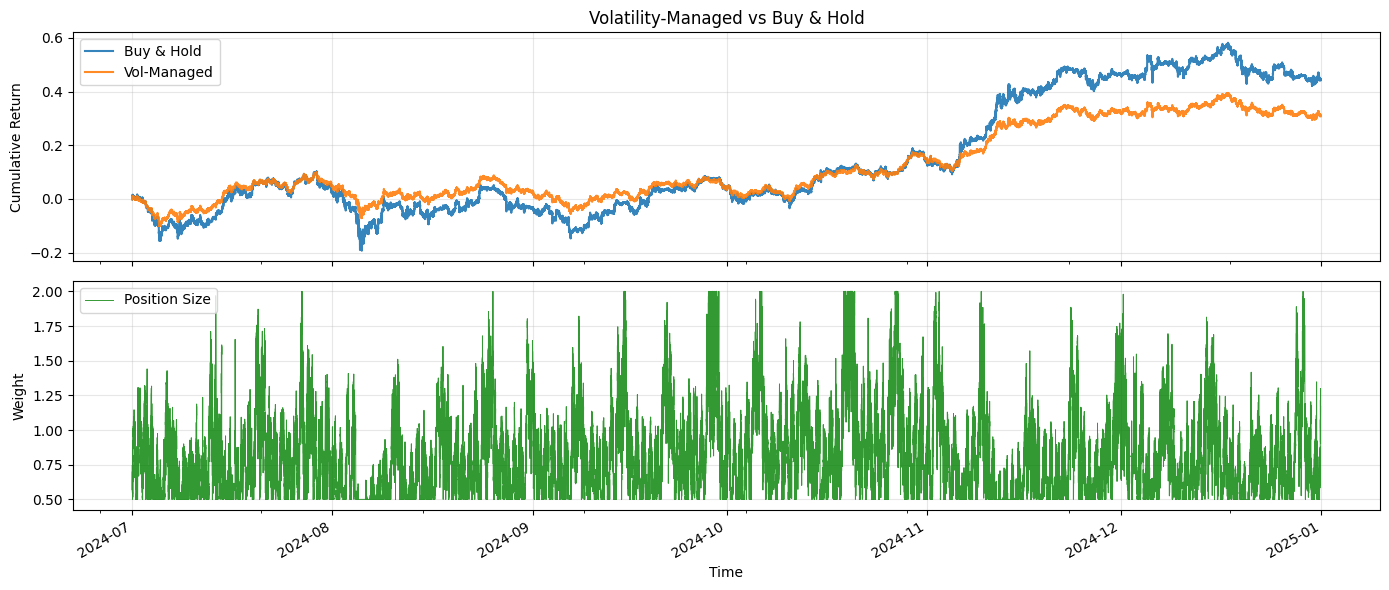

In [17]:
pretest_rv = df.loc["2023-01-01":"2024-06-30", "target_rv_fwd60m"]

sigma_target = np.median(pretest_rv)
print(f"Median of pre-test realized vol: {sigma_target:.4f}\n")

oos_pred = pd.Series(oos_pred, index=test_df.index)

actual_returns = df["log_ret_1m"].loc[test_df.index].shift(-1)   # your actual next-period returns

strat_ret, base_ret, metrics, w = bt.vol_managed_backtest(
    returns=actual_returns,
    pred_vol=oos_pred,
    sigma_target=sigma_target
)

table = bt.metrics_to_table(metrics)
display(table.round(4))
bt.plot_backtest(strat_ret, base_ret, w)